In [7]:
from __future__ import division
import numpy as np
import os
from PIL import Image
from IPython.display import display
import glob
import random
import ipympl
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [2]:
root = os.getcwd()
data_path = "extracted_images"
dataset_dir ="dataset"

In [12]:
def generate_datasets(data_dir, out_folder):
    """
    Divide features and label in two different datasets
    """
    from shutil import copyfile
    features_dir = os.path.join(out_folder, "features")
    labels_dir = os.path.join(out_folder, "labels")
    
    if os.path.isdir(out_folder):
        print("dataset folder already present.")
        pass
    else:
        os.mkdir(out_folder)
        os.mkdir(features_dir)
        os.mkdir(labels_dir)
        
    data_folders = os.listdir(data_dir)
    for folder in data_folders:
        if folder[0] == ".":
                continue
        symbols = os.listdir(os.path.join(data_dir, folder))
        os.mkdir(os.path.join(features_dir, folder))
        os.mkdir(os.path.join(labels_dir, folder))
        for symbol in symbols:
            if symbol[0] == ".":
                continue
            old_path = os.path.join(data_dir, os.path.join(folder, symbol))
            if "_" in symbol:
                new_path = os.path.join(labels_dir, os.path.join(folder, symbol))
            else:
                new_path = os.path.join(features_dir, os.path.join(folder, symbol))
            copyfile(old_path, new_path)

In [13]:
generate_datasets("extracted_images", dataset_dir)

In [2]:
def disp_sample(folders_path, sample_size):
    basename = os.path.basename(folders_path)
    folders = os.listdir(folders_path)
    for folder in folders:
        if folder.startswith("."):
            continue
        print("{}/{}".format(basename, folder))
        folder_path = os.path.join(folders_path, folder)
        image_files = os.listdir(folder_path)
        if len(image_files) == 0:
            continue
        image_samples = random.sample(image_files, sample_size)
        for image in image_samples:
            image_file = os.path.join(folders_path, os.path.join(folder, image))
            i = Image.open(image_file)
            display(i)

features/beta


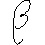

features/pm


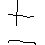

features/Delta


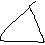

features/gamma


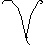

features/infty


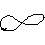

features/rightarrow


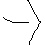

features/div


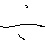

features/gt


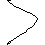

features/forward_slash
features/leq


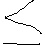

features/mu


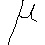

features/exists


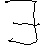

features/in


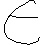

features/times


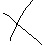

features/sin


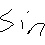

features/R


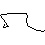

features/u


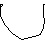

features/9


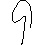

features/0


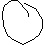

features/{


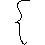

features/7


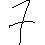

features/i


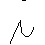

features/N


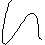

features/G


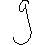

features/+


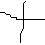

features/,


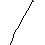

features/6


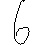

features/z


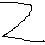

features/}


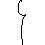

features/1


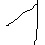

features/8


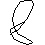

features/T


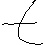

features/S


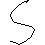

features/cos


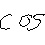

features/A


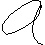

features/-


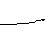

features/f


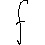

features/o


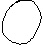

features/H


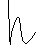

features/sigma


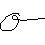

features/sqrt


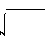

features/pi


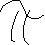

features/int


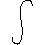

features/sum


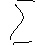

features/lim


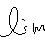

features/lambda


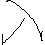

features/neq


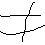

features/log


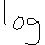

features/ldots


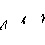

features/forall


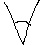

features/lt


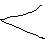

features/theta


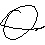

features/ascii_124


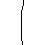

features/M


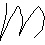

features/!


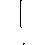

features/alpha


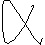

features/j


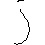

features/C


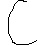

features/]


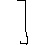

features/(


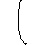

features/d


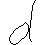

features/v


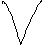

features/prime


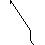

features/q


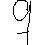

features/=


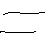

features/4


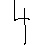

features/X


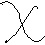

features/phi


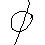

features/3


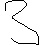

features/tan


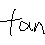

features/e


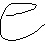

features/)


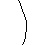

features/[


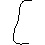

features/b


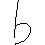

features/k


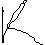

features/l


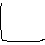

features/geq


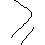

features/2


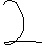

features/y


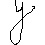

features/5


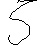

features/p


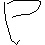

features/w


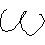

In [3]:
disp_sample("dataset/features", 1)

labels/beta


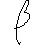

labels/pm


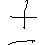

labels/Delta


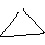

labels/gamma


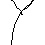

labels/infty


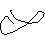

labels/rightarrow


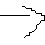

labels/div


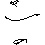

labels/gt


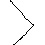

labels/forward_slash


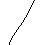

labels/leq


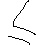

labels/mu


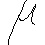

labels/exists


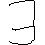

labels/in


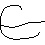

labels/times


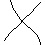

labels/sin


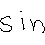

labels/R


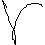

labels/u


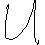

labels/9


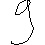

labels/0


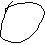

labels/{


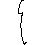

labels/7


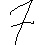

labels/i


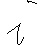

labels/N


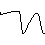

labels/G


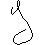

labels/+


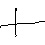

labels/,


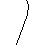

labels/6


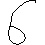

labels/z


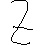

labels/}


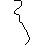

labels/1


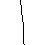

labels/8


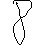

labels/T


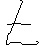

labels/S


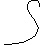

labels/cos


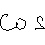

labels/A


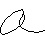

labels/-


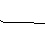

labels/f


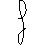

labels/o


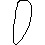

labels/H


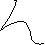

labels/sigma


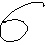

labels/sqrt


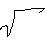

labels/pi


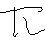

labels/int


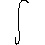

labels/sum


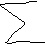

labels/lim


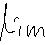

labels/lambda


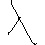

labels/neq


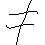

labels/log


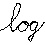

labels/ldots


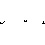

labels/forall


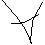

labels/lt


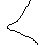

labels/theta


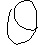

labels/ascii_124


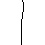

labels/M


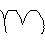

labels/!


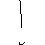

labels/alpha


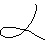

labels/j


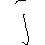

labels/C


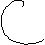

labels/]


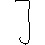

labels/(


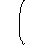

labels/d


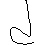

labels/v


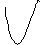

labels/prime


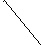

labels/q


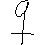

labels/=


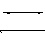

labels/4


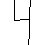

labels/X


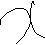

labels/phi


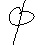

labels/3


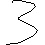

labels/tan


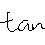

labels/e


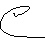

labels/)


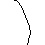

labels/[


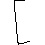

labels/b


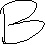

labels/k


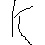

labels/l


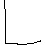

labels/geq


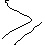

labels/2


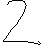

labels/y


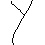

labels/5


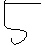

labels/p


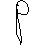

labels/w


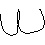

In [4]:
disp_sample("dataset/labels", 1)

## Create fake dataset for object recognition
Create a fake dataset of fixed sized images. 

In [5]:
def pick_random_samples(folders_path, sample_size):
    folders = random.sample(os.listdir(folders_path), 5)
    images = [] 
    for folder in folders:
        folder_path = os.path.join(folders_path, folder)
        image_files = os.listdir(folder_path)
        image_samples = random.sample(image_files, sample_size)
        for image in image_samples:
            image_file = os.path.join(folders_path, os.path.join(folder, image))
            i = Image.open(image_file)
            images.append(i)
            # display(i)
    return images

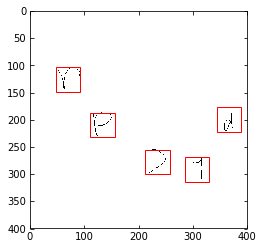

In [10]:
import ipympl
images = pick_random_samples("dataset/features", 1)
new_im = Image.new('RGB', (400, 400), color='white')
bboxes = []

def intersect(bbox1, bbox2):
       return (abs(bbox1[0] - bbox2[0]) < abs(bbox1[2] + bbox2[2]) / 2) and (abs(bbox1[1] - bbox2[1]) < (abs(bbox1[3] + bbox2[3]) / 2))

for img in images:
    min_x, max_x = img.width, new_im.width - img.width
    min_y, max_y = img.height, new_im.height - img.height
    
    x = random.randint(min_x, max_x)
    y = random.randint(min_y, max_y)
    bbox = [x, y, img.width, img.height]
    i = 0
    hasCollision = False
    while i < len(bboxes):
        if i == images.index(img):
            continue
            
        if intersect(bbox, bboxes[i]):
            # print(bbox, bboxes[i])
            x = random.randint(min_x, max_x)
            y = random.randint(min_y, max_y)
            bbox = [x, y, img.width, img.height]
            i = 0
            continue
        i += 1
    bboxes.append(bbox)
    new_im.paste(img, (x, y))

plt.imshow(new_im)
[plt.gca().add_patch(Rectangle((box[0], box[1]), box[2], box[3], ec='r', fc='none')) for box in bboxes]
plt.show()